<a href="https://colab.research.google.com/github/AnIsAsPe/Prediccion-produccion-electricidad/blob/main/notebooks/Predicci%C3%B3n_producci%C3%B3n_electricidad_Feb22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Bibliotecas

In [1]:
#import math

import numpy as np
import pandas as pd

import itertools

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


# Funciones

In [2]:
def p_value_adfuller(data):
        fuller_test = adfuller(data)
        print('P-value: ',fuller_test[1])
        if fuller_test[1] <= 0.05:
            print('Se rechaza la hipótesis nula, los datos son estacionarios')
        else:
            print('No se rechaza la hipóteis nula, los datos no son estacionarios')


# Lectura de datos

In [3]:
file = 'https://raw.githubusercontent.com/AnIsAsPe/Prediccion-produccion-electricidad/main/Datos/IPG2211A2N_Feb%2022.csv'
datos = pd.read_csv(file, index_col = [0], parse_dates=['DATE'])
datos = datos.loc['1990-01-01':]
datos.columns = ['Producción']  # NAICS 2211

datos

,Producción
DATE,
1990-01-01,83.2897
1990-02-01,76.1676
1990-03-01,72.2190
1990-04-01,66.3566
1990-05-01,64.9348
...,...
2021-10-01,90.6041
2021-11-01,97.5215
2021-12-01,108.1131


In [4]:
# revisamos si las fechas están ordenads
datos.index.is_monotonic

True

In [5]:
datos.index

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01'],
              dtype='datetime64[ns]', name='DATE', length=386, freq=None)

In [6]:
# para algunas funciones de ST es importante indicar la frecuencia de nuestros datos
datos.index.freq = datos.index.inferred_freq
datos.index

DatetimeIndex(['1990-01-01', '1990-02-01', '1990-03-01', '1990-04-01',
               '1990-05-01', '1990-06-01', '1990-07-01', '1990-08-01',
               '1990-09-01', '1990-10-01',
               ...
               '2021-05-01', '2021-06-01', '2021-07-01', '2021-08-01',
               '2021-09-01', '2021-10-01', '2021-11-01', '2021-12-01',
               '2022-01-01', '2022-02-01'],
              dtype='datetime64[ns]', name='DATE', length=386, freq='MS')

Para más información de las frecuencias en pandas consultar el apartado DateOffset objects en [este enlace](https://pandas.pydata.org/pandas-docs/stable/user_guide/timeseries.html)

# Exploración y Visualización de la Serie Temporal

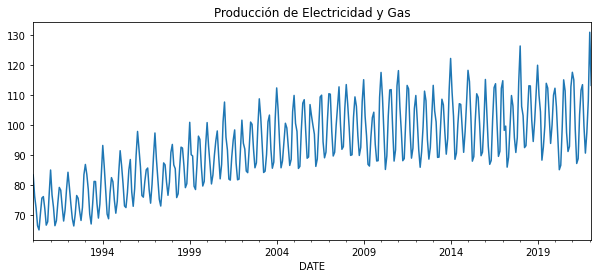

In [7]:
datos['Producción'].plot(figsize=(10,4), title='Producción de Electricidad y Gas')
plt.show()

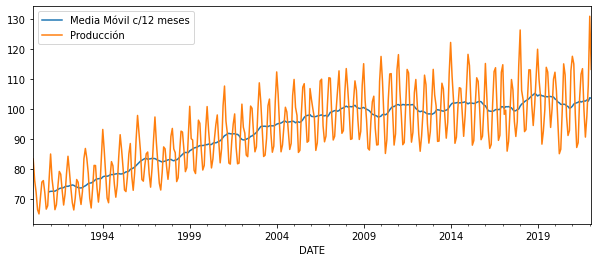

In [8]:
datos['Producción'].rolling(12).mean().plot(figsize=(10,4),label='Media Móvil c/12 meses')
datos['Producción'].plot()
plt.legend()
plt.show()

La funcion seasonal_decompose() de statsmodels, descompone la serie en tres partes: tendencia, estacionalidad y residuos.

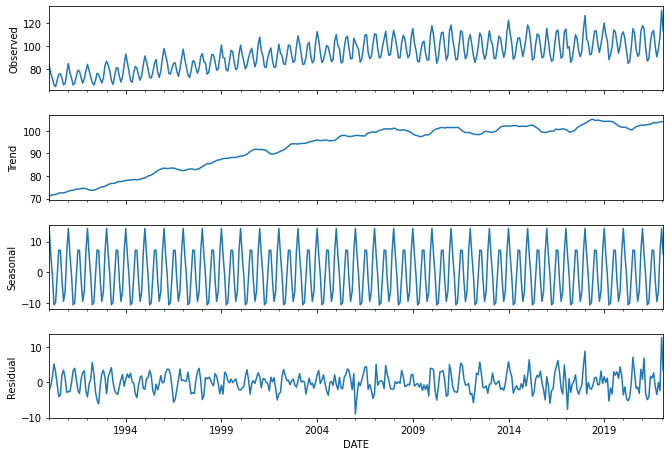

In [9]:
decomp = seasonal_decompose(datos['Producción']
                            , freq=12, extrapolate_trend='freq'
                            )
fig =decomp.plot()
fig.set_size_inches(10,7)

# Convertir los datos a Estacionarios

Realizamos el **test Dickey-Fuller** en la cual, **la hipótesis nula es que los datos no son estacionarios** (*si p es muy pequeña, rechazaremos la hipotesis nula*)
La hipotesis alternativa es que son estacionarios

In [10]:
pValue = adfuller(datos['Producción'])[1]
pValue

0.2555691067075384

In [11]:
p_value_adfuller(datos['Producción'])

P-value:  0.2555691067075384
No se rechaza la hipóteis nula, los datos no son estacionarios


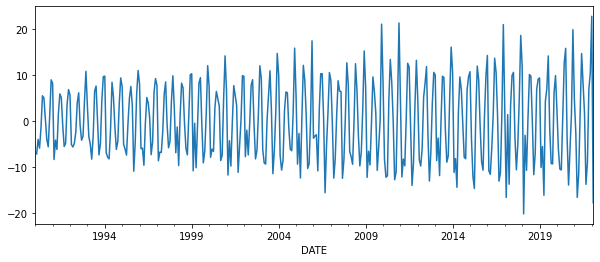

In [12]:
datos['1a diff']= datos['Producción'] - datos['Producción'].shift(1)  
datos['1a diff'].plot(figsize=(10,4))

In [13]:
p_value_adfuller(datos['1a diff'].dropna())

P-value:  9.026604210846001e-10
Se rechaza la hipótesis nula, los datos son estacionarios


# Visualización de la ACF y PACF

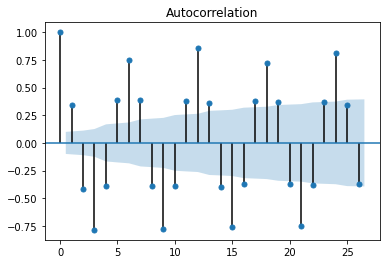

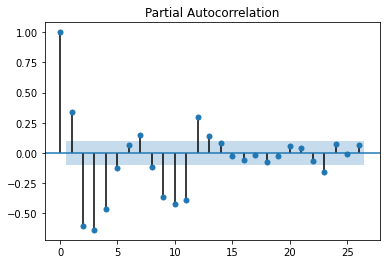

In [14]:
plot_acf(datos['1a diff'].dropna())
plot_pacf(datos['1a diff'].dropna())
plt.show()

# Construcción del modelo SARIMA



In [15]:
train = datos.loc[:'2021-02-01','Producción']
test = datos.loc['2021-02-01':,'Producción']

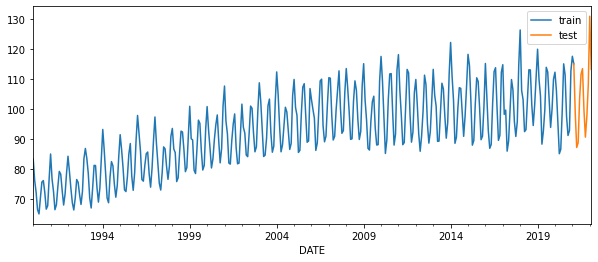

In [16]:
train.plot(label = 'train', figsize =(10,4))
test.plot(label = 'test', figsize =(10,4))
plt.legend()
plt.show()

In [17]:
p = d = q = range(0, 2)
pdq = list(itertools.product(p, d, q))
pdq

[(0, 0, 0),
 (0, 0, 1),
 (0, 1, 0),
 (0, 1, 1),
 (1, 0, 0),
 (1, 0, 1),
 (1, 1, 0),
 (1, 1, 1)]

In [18]:
seasonal_pdq = [(x[0], x[1], x[2], 12) for x in list(itertools.product(p, d, q))]
seasonal_pdq

[(0, 0, 0, 12),
 (0, 0, 1, 12),
 (0, 1, 0, 12),
 (0, 1, 1, 12),
 (1, 0, 0, 12),
 (1, 0, 1, 12),
 (1, 1, 0, 12),
 (1, 1, 1, 12)]

In [19]:
aic_modelos = {}
for parametros in pdq:
  for parametros_s in seasonal_pdq:
      modelo = SARIMAX(datos.loc[:'2021-02-01','Producción'],
                       order = parametros,
                       seasonal_order = parametros_s,
                       enforce_stationarity = False,
                       enforce_invertibility = False)
      results = modelo.fit(method_kwargs={"warn_convergence": False})
      aic_modelos[parametros, parametros_s] = results.aic
      print('ARIMA{} x {} - AIC:{}'.format(parametros, parametros_s, results.aic))  

ARIMA(0, 0, 0) x (0, 0, 0, 12) - AIC:4446.749816952196
ARIMA(0, 0, 0) x (0, 0, 1, 12) - AIC:3866.0481434534377
ARIMA(0, 0, 0) x (0, 1, 0, 12) - AIC:1998.1789401820097
ARIMA(0, 0, 0) x (0, 1, 1, 12) - AIC:1921.9144935630206
ARIMA(0, 0, 0) x (1, 0, 0, 12) - AIC:1986.8584060098392
ARIMA(0, 0, 0) x (1, 0, 1, 12) - AIC:1929.401325147485
ARIMA(0, 0, 0) x (1, 1, 0, 12) - AIC:1931.7433136977206
ARIMA(0, 0, 0) x (1, 1, 1, 12) - AIC:1923.86652990866
ARIMA(0, 0, 1) x (0, 0, 0, 12) - AIC:3955.924606113856
ARIMA(0, 0, 1) x (0, 0, 1, 12) - AIC:3407.663274162925
ARIMA(0, 0, 1) x (0, 1, 0, 12) - AIC:1880.2381649092633
ARIMA(0, 0, 1) x (0, 1, 1, 12) - AIC:1792.2027238834498
ARIMA(0, 0, 1) x (1, 0, 0, 12) - AIC:1881.3092647084034
ARIMA(0, 0, 1) x (1, 0, 1, 12) - AIC:1806.9213897704576
ARIMA(0, 0, 1) x (1, 1, 0, 12) - AIC:1812.6240040617954
ARIMA(0, 0, 1) x (1, 1, 1, 12) - AIC:1794.3550179357983
ARIMA(0, 1, 0) x (0, 0, 0, 12) - AIC:2628.502709893748
ARIMA(0, 1, 0) x (0, 0, 1, 12) - AIC:2286.0055170767682

In [20]:
print('Modelo: ', min(aic_modelos, key = aic_modelos.get))
print('AIC: ',min(aic_modelos.values()))


Modelo:  ((1, 1, 1), (0, 1, 1, 12))
AIC:  1671.6596118725706


In [21]:
modelo = SARIMAX(datos['Producción'],
                       order = (1,1,1),
                       seasonal_order = (0,1,1,12),
                       enforce_stationarity = False,
                       enforce_invertibility = False)
resultados = modelo.fit()
print(resultados.summary().tables[1])

                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.4515      0.049      9.236      0.000       0.356       0.547
ma.L1         -0.9488      0.019    -48.715      0.000      -0.987      -0.911
ma.S.L12      -0.7898      0.037    -21.604      0.000      -0.861      -0.718
sigma2         7.5308      0.413     18.234      0.000       6.721       8.340


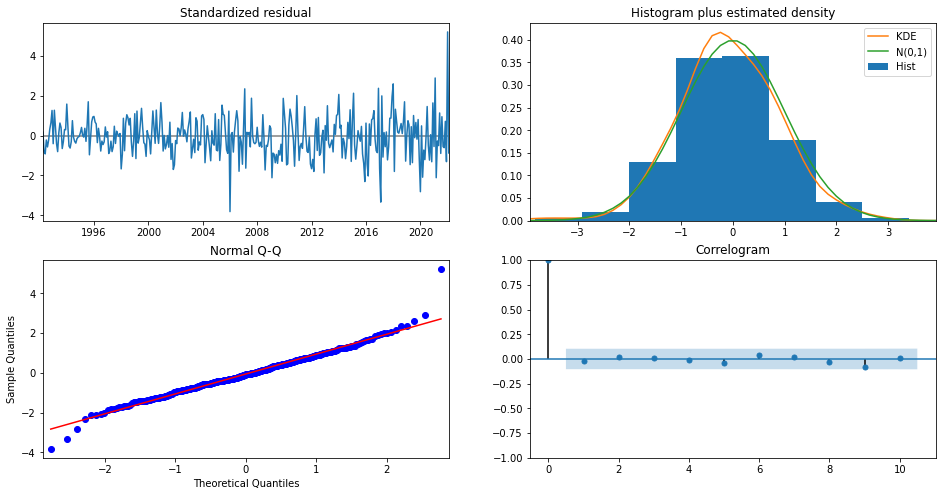

In [22]:
resultados.plot_diagnostics(figsize = (16,8))
plt.show()

# Validación

In [31]:
pred = resultados.get_prediction(start=pd.to_datetime('2021-02-01'),
                                 end=pd.to_datetime('2022-06-01'))
pred.predicted_mean

2021-02-01    107.121753
2021-03-01    104.288580
2021-04-01     87.872002
2021-05-01     90.101179
2021-06-01    100.353491
2021-07-01    114.099680
2021-08-01    110.870074
2021-09-01    101.234285
2021-10-01     92.258984
2021-11-01     95.543081
2021-12-01    111.699189
2022-01-01    116.687580
2022-02-01    115.625270
2022-03-01    102.586351
2022-04-01     90.148981
2022-05-01     91.783806
2022-06-01    103.056548
Freq: MS, dtype: float64

In [32]:
#intervalo de confianza
pred_IC = pred.conf_int()
pred_IC

,lower Producción,upper Producción
2021-02-01,101.743175,112.500330
2021-03-01,98.910002,109.667157
2021-04-01,82.493424,93.250579
2021-05-01,84.722602,95.479757
2021-06-01,94.974913,105.732069
2021-07-01,108.721103,119.478258
2021-08-01,105.491496,116.248652
2021-09-01,95.855708,106.612863
2021-10-01,86.880406,97.637561
2021-11-01,90.164503,100.921659


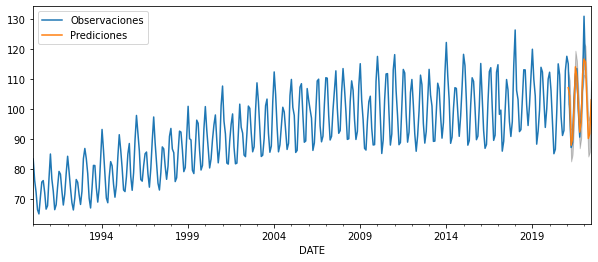

In [33]:
fig = datos.loc[:,'Producción'].plot(label = 'Observaciones', 
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.legend()
plt.show()

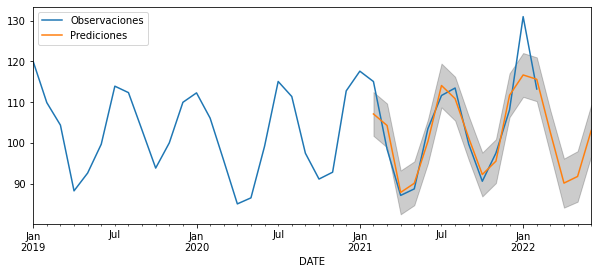

In [34]:
fig = datos.loc['2019-01-01':,'Producción'].plot(label = 'Observaciones', 
                                           figsize =(10,4))
pred.predicted_mean.plot(ax = fig, label = 'Prediciones')
fig.fill_between(pred_IC.index, 
                 pred_IC.iloc[:,0], pred_IC.iloc[:,1], 
                 color='k', alpha=.2)
plt.legend()
plt.show()

In [35]:
y_pred  = pred.predicted_mean
y_real = datos.loc['2021-02-01':'2022-02-01','Producción']
mse = ((y_pred - y_real) ** 2).mean()
print('El error cuadrático medio es {}'.format(round(mse, 2)))
print('La raiz del error cuadrático medio es {}'.format(round(np.sqrt(mse), 2)))

El error cuadrático medio es 27.24
La raiz del error cuadrático medio es 5.22
